# Imports & Other Setup

In [5]:
# !conda activate n2v
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
import sys
import torch
import random
import zarr
from PIL import Image
from skimage import data
from skimage import filters
from skimage import metrics
import os

from funlib.learn.torch.models import UNet, ConvPass
import gunpowder as gp
import logging
logging.basicConfig(level=logging.INFO)

# from this repo
import loser
from boilerPlate import BoilerPlate
# from segway.tasks.make_zarr_from_tiff import task_make_zarr_from_tiff_volume as tif2zarr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#Pick a GPU or 2
torch.cuda.set_device(3)

In [10]:
def imshow(raw, mask=None, hot=None, prediction=None, context=None):
  cols = 1 + (mask is not None) + (hot is not None) + (prediction is not None) + (context is not None)
  fig, axes = plt.subplots(1, cols, figsize=(50,50*cols))
  if len(raw.shape) == 3:
    middle = raw.shape[0] // 2
    axes[0].imshow(raw[middle], cmap='gray', vmin=0, vmax=1)
  else:
    axes[0].imshow(raw, cmap='gray', vmin=0, vmax=1)
  col = 1
  if mask is not None:
    if len(mask.shape) == 3:
      axes[col].imshow(mask[middle], vmin=0, vmax=1)
    else:
      axes[col].imshow(mask, vmin=0, vmax=1)
    col += 1
  if hot is not None:
    if len(hot.shape) == 3:
      axes[col].imshow(hot[middle], cmap='gray', vmin=0, vmax=1)
    else:
      axes[col].imshow(hot, cmap='gray', vmin=0, vmax=1)
    col += 1
  if prediction is not None:
    if prediction.size < raw.size:
      pads = np.subtract(raw.shape, prediction.shape) // 2
      pad_tuple = []
      for p in pads:
          pad_tuple.append((p, p))
      prediction = np.pad(prediction, tuple(pad_tuple))
    if len(prediction.shape) == 3:
      axes[col].imshow(prediction[middle], cmap='gray', vmin=0, vmax=1)
    else:
      axes[col].imshow(prediction, cmap='gray', vmin=0, vmax=1)
    col += 1
  if context is not None:
    if len(hot.shape) == 3:
      axes[col].imshow(context[middle], cmap='gray', vmin=0, vmax=1)
    else:
      axes[col].imshow(context, cmap='gray', vmin=0, vmax=1)
    col += 1
  
  plt.show()

In [12]:
def batch_show(batch, i=0):

    imshow(batch[raw].data[i].squeeze(), 
        batch[mask].data[i].squeeze(), 
        batch[hot].crop(batch[raw].spec.roi).data[i].squeeze(),
        batch[prediction].data[i].squeeze(),
        batch[hot].data[i].squeeze()
        )
        

# Set Parameters (including data source, training variables, destination, etc.)

## **Paths for training, predictions and results**

**`train_source:`:** This is the path to your folders containing the Training_source (noisy images). To find the path of the folder containing your datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Do not re-use the name of an existing model (saved in the same folder), otherwise it will be overwritten.

**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).


## **Training parameters**

**`num_epochs`:** Input how many epochs (rounds) the network will be trained. Preliminary results can already be observed after a few (10-30) epochs, but a full training should run for 100-200 epochs. Evaluate the performance after training (see 5.). **Default value: 30**

**`side_length`:** Noise2Void divides the image into patches for training. Input the size of the patches (length of a side). The value should be smaller than the dimensions of the image and divisible by 8. **Default value: 100**

**If you get an Out of memory (OOM) error during the training, manually decrease the patch_size values until the OOM error disappear.**

**`batch_size:`** This parameter defines the number of patches seen in each training step. Noise2Void requires a large batch size for stable training. Reduce this parameter if your GPU runs out of memory. **Default value: 1**

**`num_steps`:** Define the number of training steps by epoch. By default this parameter is calculated so that each image / patch is seen at least once per epoch. **Default value: Number of patch / batch_size**

**`perc_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10** 

**`init_learn_rate`:** Input the initial value to be used as learning rate. **Default value: 0.0004**

**`perc_hotPixels:`** Percent of output pixels to designate as targets and *heat* for training **Default value: 0.198**


In [17]:
train_source = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/mCTX_17keV_30nm_512c_first256.zarr' #EXPECTS ZARR VOLUME
#TODO: MAKE ABLE TO HANDLE TIFF VOLUME OR STACK

data_name = 'mCTX_17keV_30nm_512c_first256'
data_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/'
data_format = 'zarr'

tensorboard_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/tensorboard/'
model_name = 'noise2gun_mCTX30nm_450p'
model_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/models/'
#os.chdir(model_path)
voxel_size=gp.Coordinate((30, 30, 30)) # set for each dataset (may be able to get from zarr)

side_length = 32#12 # in voxels for prediction (i.e. network output) - actual used ROI for network input will be bigger for valid padding
unet_depth = 4 # number of layers in unet
downsample_factor = 2
conv_padding = 'valid'
num_fmaps = 12
fmap_inc_factor=5
perc_hotPixels = 0.198
constant_upsample=True

num_epochs = 10000
batch_size = 1
init_learning_rate = 1e-6 # init_learn_rate = 0.0004
log_every=100

### Make sure data source is a **zarr** 

# Build Gunpowder Pipeline for Training

### Elements are:

- Data Source
- *(optional) Normalization*
- Random Patch Grab
- Pixel Heating (select and mutate *hotPixels*, i.e. training targets, and keep masks)
- Simple Augmentation (rotations/reflections)
- Stacking
- Training


In [58]:
%autoreload
from boilerPlate import BoilerPlate
import loser

In [18]:
# declare arrays to use in the pipeline
raw = gp.ArrayKey('RAW') # raw data
hot = gp.ArrayKey('HOT') # data with random pixels heated
mask = gp.ArrayKey('MASK') # data with random pixels heated
prediction = gp.ArrayKey('PREDICTION') # prediction of denoised data

source = gp.ZarrSource(    # add the data source
    train_source,  # the zarr container
    {raw: 'volumes/train'},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True)}  # meta-information
)

# add normalization
normalize = gp.Normalize(raw)

# add a RandomLocation node to the pipeline to randomly select a sample
random_location = gp.RandomLocation()

# add transpositions/reflections
simple_augment = gp.SimpleAugment()

# stack for batches
stack = gp.Stack(batch_size)

# add pixel heater
boilerPlate = BoilerPlate(raw, mask, hot, plate_size=side_length, perc_hotPixels=perc_hotPixels, ndims=3)

# prepare tensors for UNet
unsqueeze = gp.Unsqueeze([hot, mask, raw])

# setup a cache
cache = gp.PreCache(num_workers=os.cpu_count()//4)

# define our network model for training
unet = UNet(
  in_channels=1,
  num_fmaps=num_fmaps,
  fmap_inc_factor=fmap_inc_factor,
  downsample_factors=[(downsample_factor,)*3,] * (unet_depth - 1),
  padding=conv_padding,
  constant_upsample=constant_upsample,
  voxel_size=voxel_size # set for each dataset
  )

model = torch.nn.Sequential(
  unet,
  ConvPass(num_fmaps, 1, [(1, 1, 1)], activation=None),
  torch.nn.Sigmoid())

# pick loss function
loss = loser.maskedMSE

# pick optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=init_learning_rate)

# create a train node using our model, loss, and optimizer
train = gp.torch.Train(
  model,
  loss,
  optimizer,
  inputs = {
    'input': hot
  },
  loss_inputs = {
    'src': prediction,
    'mask': mask,
    'target': raw
  },
  outputs = {
    0: prediction
  },
  log_dir=tensorboard_path,
  log_every=log_every,
  checkpoint_basename=model_name,
  #save_every=log_every
  )

# figure out proper ROI padding for context
conv_passes = 2 # set by default in unet
kernel_size = 3 # set by default in unet
context_side_length = 2 * np.sum([(conv_passes * (kernel_size - 1)) * (2 ** level) for level in np.arange(unet_depth - 1)]) + (conv_passes * (kernel_size - 1)) * (2 ** (unet_depth - 1)) + (conv_passes * (kernel_size - 1)) + side_length

# create request
request = gp.BatchRequest()
request.add(raw, voxel_size*side_length)
request.add(mask, voxel_size*side_length)
request.add(hot, voxel_size*context_side_length) # debugg later
request.add(prediction, voxel_size*side_length)

# get performance stats
performance = gp.PrintProfilingStats(every=log_every)

# assemble pipeline
pipeline = (source +
            normalize + 
            random_location +
            simple_augment + 
            boilerPlate +
            unsqueeze + 
            #cache +
            stack + 
            train +
            performance
            )

# Train

In [70]:
#Test run
with gp.build(pipeline):
  batch = pipeline.request_batch(request)

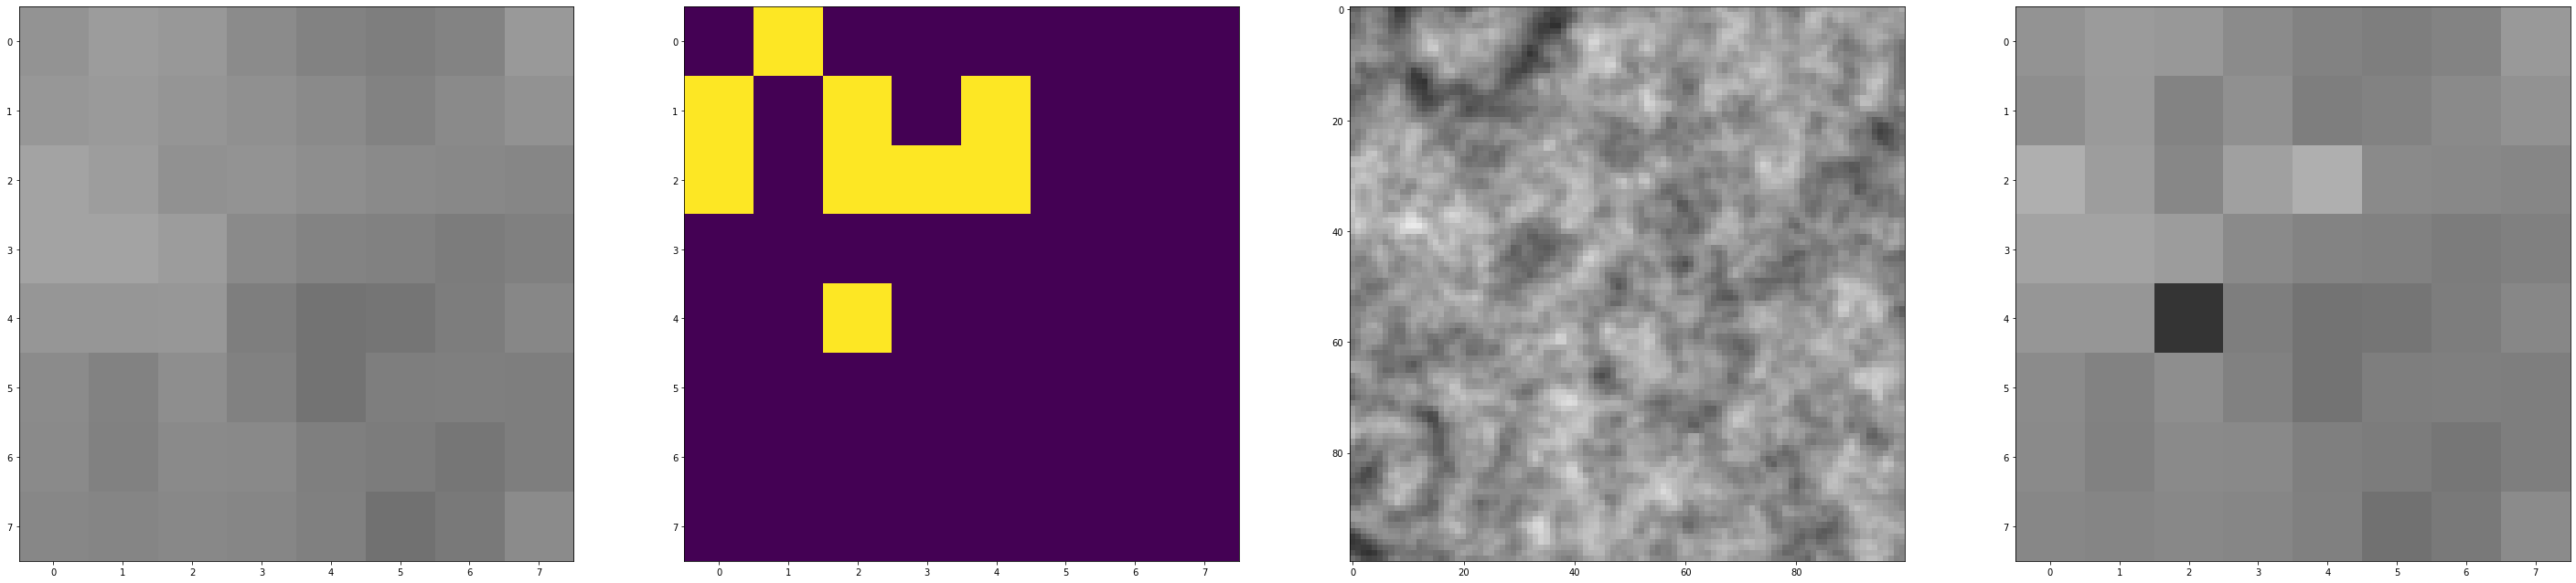

In [71]:
#Check initial results
i = 0
imshow(batch[raw].data[i].squeeze(), 
        batch[mask].data[i].squeeze(), 
        batch[hot].data[i].squeeze(), 
        #batch[prediction].data[i].squeeze()
        batch[hot].crop(batch[raw].spec.roi).data[i].squeeze()
        )

In [72]:
#Train for real
#NOTE: MAY NEED TO REBUILD PIPELINE FIRST
with gp.build(pipeline):
  for i in range(num_epochs):
    batch = pipeline.request_batch(request)
    if np.mod(i, log_every) == 0:
      batch_show(batch)

# Examine Results

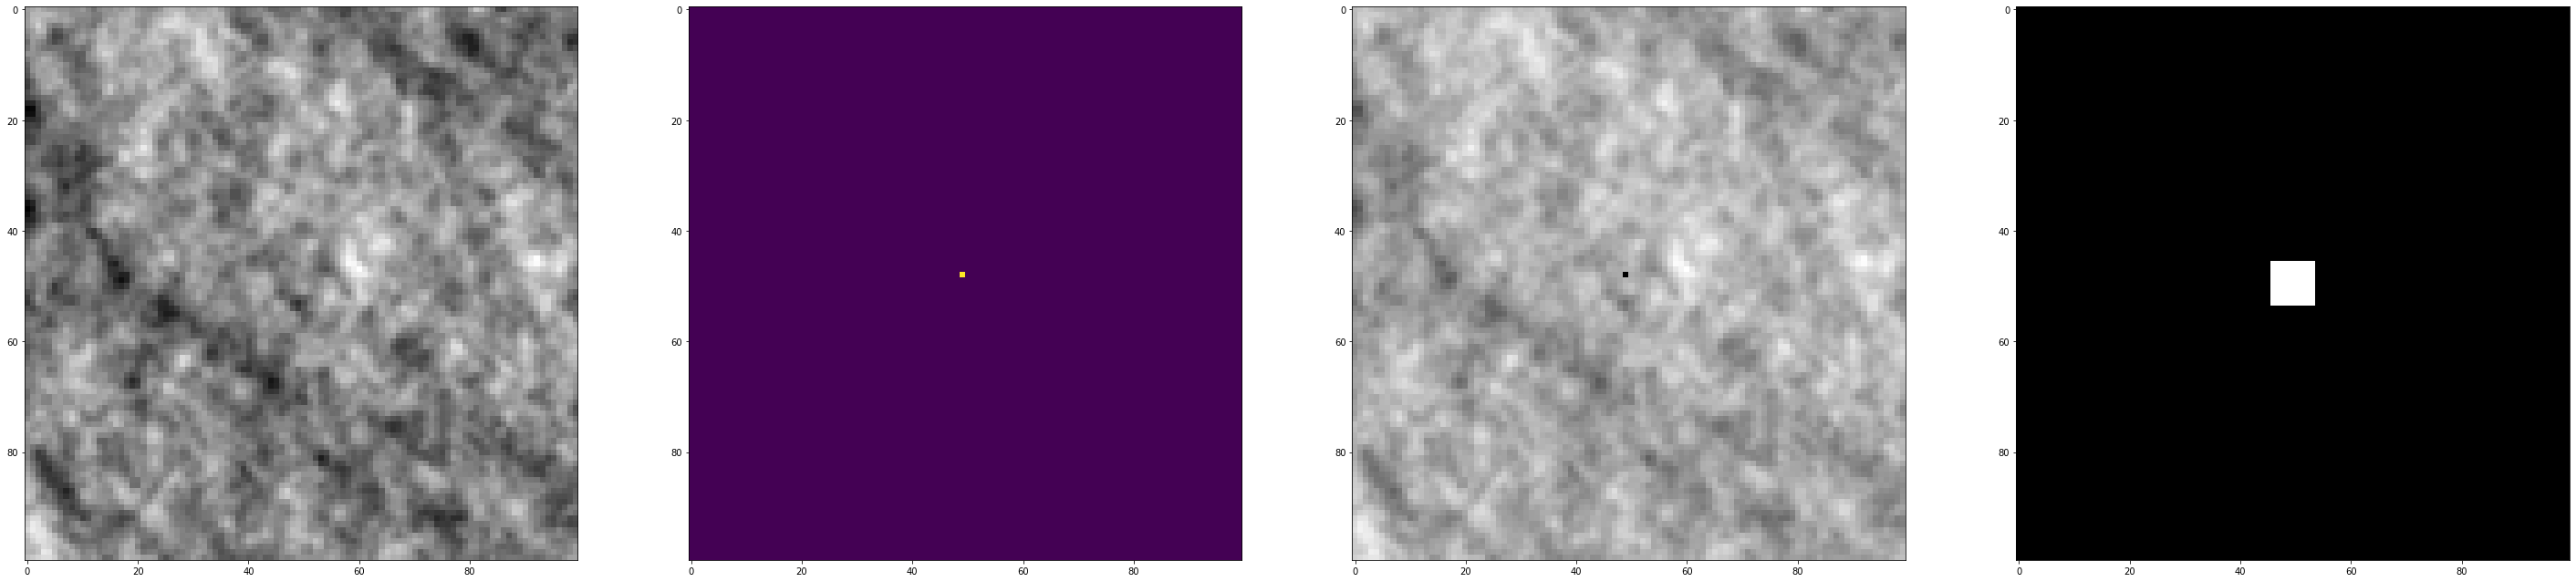

In [23]:
#Check results
i = 0
imshow(batch[raw].data[i].squeeze(), 
        batch[mask].data[i].squeeze(), 
        batch[hot].data[i].squeeze(), 
        batch[prediction].data[i].squeeze())

# Build Prediction Pipeline

# Scratch work and trouble shooting

In [11]:
%autoreload
from boilerPlate import BoilerPlate
import loser

In [42]:
mask_data = batch[mask].data[0].squeeze()
np.sum(mask_data)

53

In [38]:
import torch.nn.functional as F
from torch import nn
from loser import *

In [39]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

model = nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
#loss = my_loss(output, target)
loss = lossFunctionN2V()
loss.backward()
print(model.weight.grad)

/mnt/orchestra_nfs/users/jlr54/envs/miniconda3/envs/n2v/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


AttributeError: 'MaskedMSELoss' object has no attribute 'backward'

In [26]:
test = tuple([torch.tensor(0),torch.tensor(0),torch.tensor(1),torch.tensor(1)])
test[::-1]

(tensor(1), tensor(1), tensor(0), tensor(0))